# Traffic Prediction Using NN e LSTM

In this notebook I apply a long-short term memory network to predict the traffic intensity in the city of Porto. I compare the performance of this method with the traditional artificial neural networks, _i.e._ multilayer perceptron.
The two models bested the baseline created for this data, having both similar performances, but the LSTM has a smaller mean square error, of 0.01653 on the test data.

### Imports and initial configurations

In [1]:
import numpy  as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from   keras.preprocessing.sequence    import TimeseriesGenerator
from   statsmodels.tools.eval_measures import rmse
from   sklearn.neural_network          import MLPRegressor
from   sklearn.metrics                 import mean_squared_error
from   sklearn.preprocessing           import MinMaxScaler
from   keras.models import Sequential
from   keras.layers import Dense
from   keras.layers import LSTM
from   keras.layers import Dropout

warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'

Using TensorFlow backend.


### Data Processing

In [2]:
# Read data.
df = pd.read_csv('14_hourly.csv')

# Create train and test datasets for the neural networks.
# First 500 observations for training (~70%) and 210 for test.
n_inputs = 144
n_outputs = 12
dataset = []
for i in range(len(df)-(n_inputs+n_outputs)):
    dataset.append(df.loc[i:(i+n_inputs+n_outputs-1), "value"].tolist())
df2 = pd.DataFrame(dataset)
X = df2.loc[:, 0:(n_inputs-1)]
y = df2.loc[:, n_inputs:(n_inputs+n_outputs-1)]
# Split the data.
divider = int(len(df2)*0.8)
X_train, X_test, y_train, y_test = X[:divider], X[divider:], y[:divider], y[divider:]

# Normalize the data.
Xscaler = MinMaxScaler()
Xscaler.fit(X_train)
X_train = Xscaler.transform(X_train)
X_test = Xscaler.transform(X_test)

Yscaler = MinMaxScaler()
Yscaler.fit(y_train)
y_train = Yscaler.transform(y_train)
y_test = Yscaler.transform(y_test)

The time series used for this project contains the traffic intensity, i.e. number of cars, per hour in the street João Pedro Ribeiro in Constituição, Porto from April, 2016.

The time series contains data for the entire month of April 2016, from 01:00 01/04/2016 to 14:00 30/04/2016, resulting in a total of 710 observations. By looking at figure 2 we can observe that there is no evident trend and there is a cyclic component. The traffic intensity has a peek during the day and reach it’s lowest point between 3 and 7 in the morning.  

It’s also possible to observe that during the weekend the peek is lower than during the weekday, being lowest during the Sunday. We can also notice that the last Monday (6th peek counting from the end) doesn’t follow the same pattern as the others. This Monday corresponds to the 25th April, which is a holiday in Portugal (Dia da Liberdade) and the traffic behavior is similar to a Sunday.

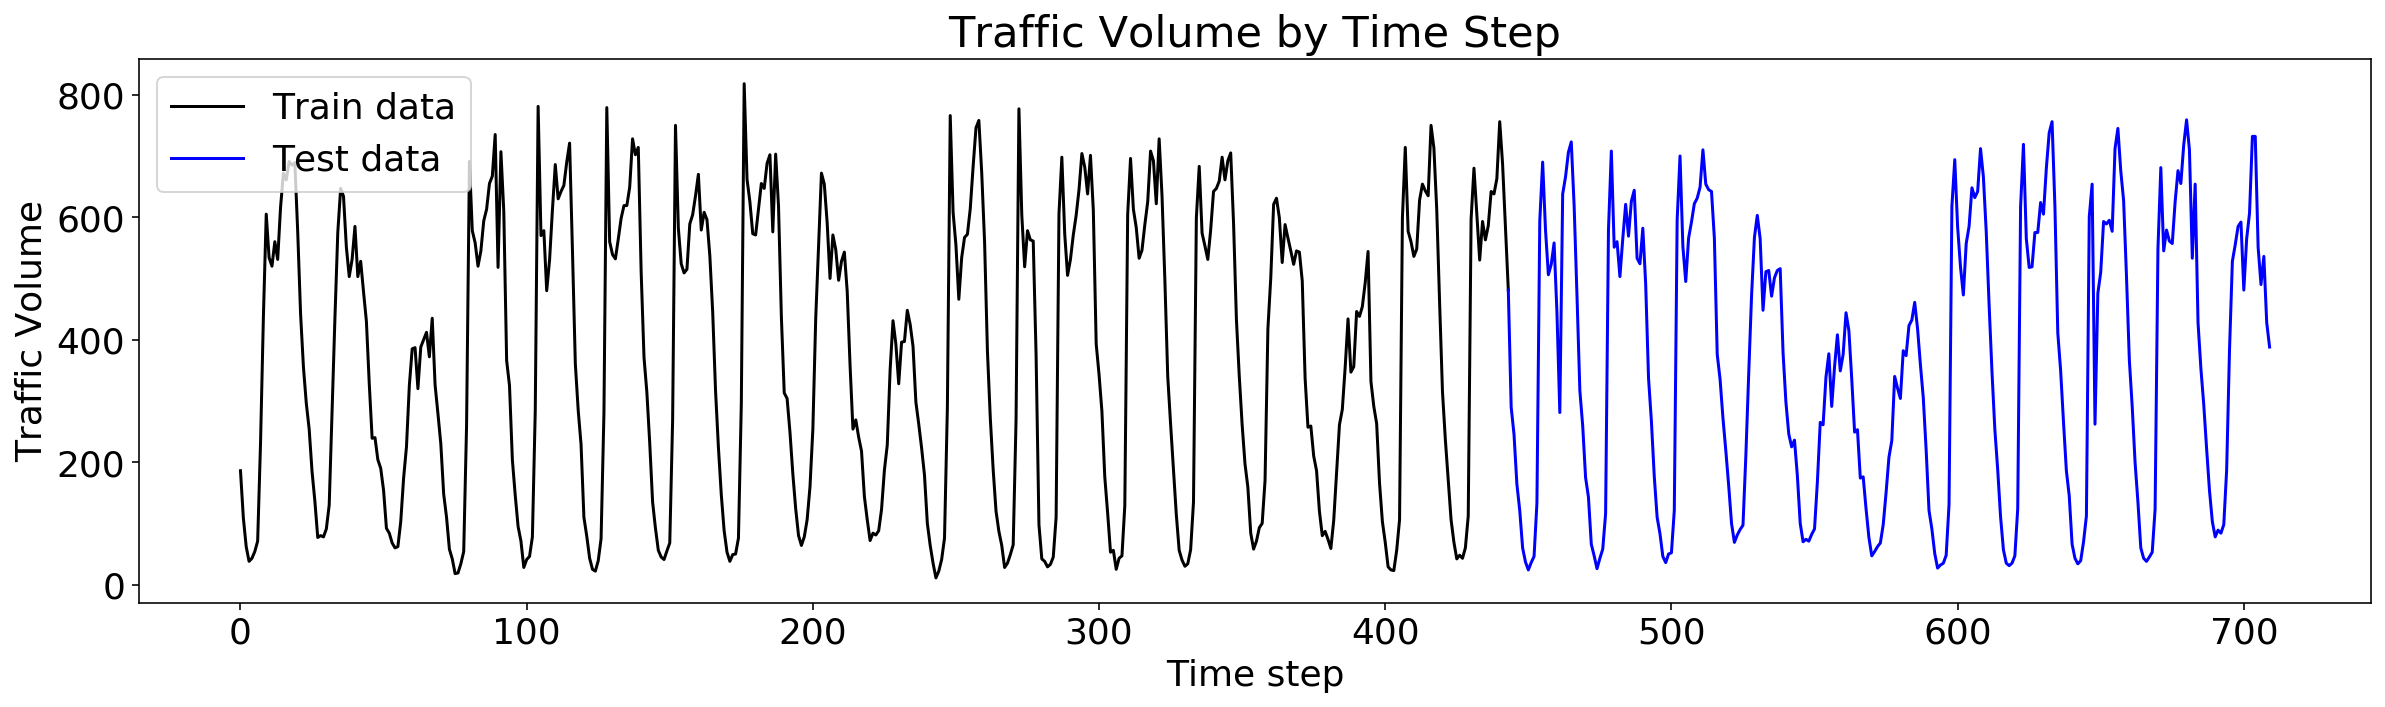

In [7]:
# Create plot to show training and testing data.
plt.figure(figsize=(20, 5))
plt.rcParams.update({'font.size': 18})
plt.plot(df.loc[:divider,"value"].index, df.loc[:divider,"value"], "black")
plt.plot(df.loc[divider:,"value"].index, df.loc[divider:,"value"], "blue")
plt.legend(["Train data", "Test data"])
plt.xlabel("Time step")
plt.ylabel("Traffic Volume")
plt.title("Traffic Volume by Time Step")
plt.savefig("train_test_data.png")

Analysing the distribution of traffic volume by hour for the entire month of April we conclude that the hours with more congestion are 8, 9, 10 and 11 am, being 7 am, 10 pm and 11 pm also high. It’s also possible to see that the traffic is decreasing over time after 8 am until 9 pm.

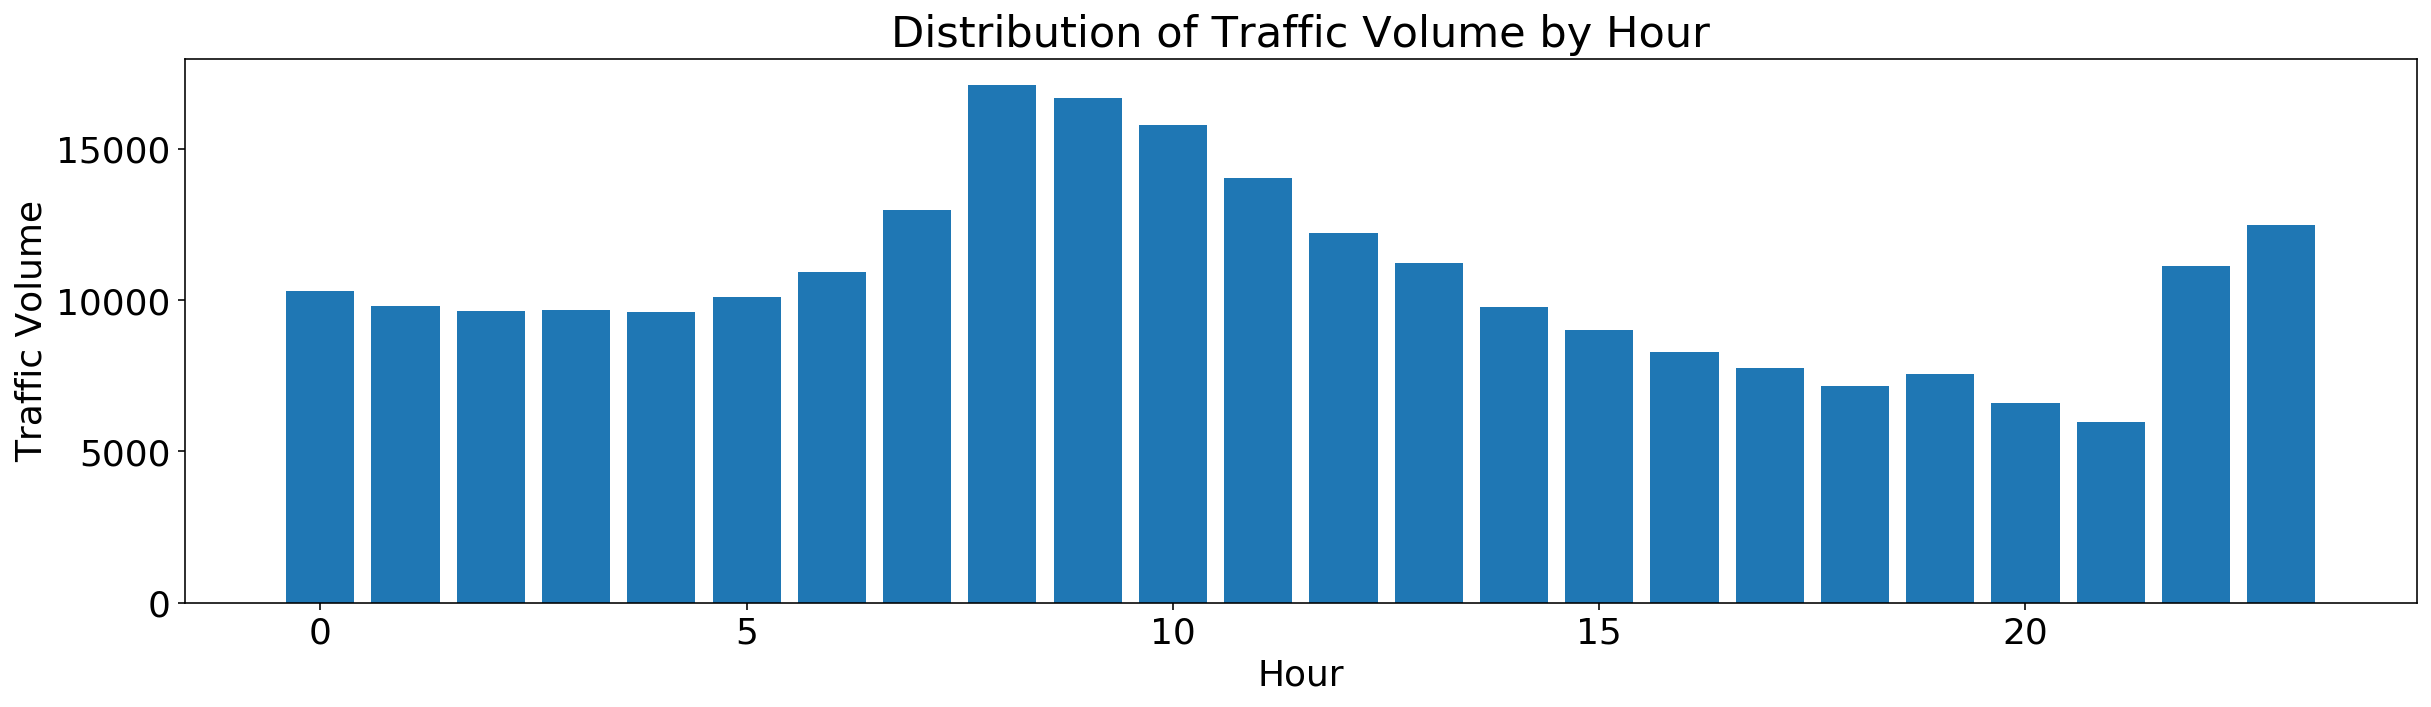

In [6]:
# Create distribution of traffic volume per hour.
freq = {}
for day in range(29):
    for hour in range(24):
        freq[hour] = freq.get(hour, 0) + df.loc[day*24+hour, "value"]
plt.figure(figsize=(20, 5))
plt.bar(freq.keys(), freq.values())
plt.xlabel("Hour")
plt.ylabel("Traffic Volume")
plt.title("Distribution of Traffic Volume by Hour")
plt.savefig("hour_distribution.png")

### Baseline Model

In order to understand if the model is actually useful I defined a baseline model that predicts the mean of the values of the 144 inputs for all the 12 outputs.

In [8]:
y_baseline = []
for mean in [sum(obs)/len(obs) for i, obs in enumerate(X_test) if i%12 == 0]:
    y_baseline.append([mean]*12)
y_baseline = Yscaler.inverse_transform(y_baseline)
plt.figure(figsize=(20, 5))
plt.rcParams.update({'font.size': 18})
plt.plot(df.loc[divider:,"value"].index, df.loc[divider:,"value"], "blue")
plt.plot(df.loc[divider+147:,"value"].index, y_baseline.ravel(), "red")
plt.legend(["Test data", "Baseline Model Prediction"], loc="upper left")
plt.xlabel("Time step")
plt.ylabel("Traffic Volume")
plt.title("Traffic Volume Prediction with Baseline Model")
plt.savefig("baseline_model.png")

#### Baseline model MSE

In [9]:
y_baseline = []
for mean in [sum(obs)/len(obs) for i, obs in enumerate(X_test)]:
    y_baseline.append([mean]*12)
sum([sum((y1-y2)**2) for y1, y2 in zip(y_baseline, y_test)]) / (len(y_test)*12)

0.1002198692792495

### Long-Short Term Memory

In [10]:
# Reshape input date to feed the network.
X_train = X_train.reshape(len(X_train), 1, n_inputs)
y_train = y_train.reshape(len(y_train), 1, n_outputs)

In [11]:
# Create the model.
model = Sequential()
model.add(LSTM(n_outputs, input_shape=(1, n_inputs), return_sequences=True, activation="sigmoid"))
model.compile(loss="mse", optimizer="adam", metrics=["mse"])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 12)             7536      
Total params: 7,536
Trainable params: 7,536
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Train the model.
history = model.fit(X_train, y_train, epochs=5000, validation_data=(X_train, y_train))

In [14]:
# Loss history lot.
plt.figure(figsize=(20, 5))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("MSE by Epoch")
plt.savefig("loss_history.png", bbox_inches='tight')

#### Test MSE for LSTM

In [16]:
y_pred = model.predict(X_test.reshape(len(X_test), 1, len(X_test[0])))
sum((y_pred.ravel() - y_test.ravel())**2)/len(y_test.ravel())

0.0165322666415901


#### Train MSE for LSTM

In [18]:
y_train_pred = model.predict(X_train)
sum((y_train_pred.ravel() - y_train.ravel())**2)/len(y_train.ravel())

0.00966747901943983


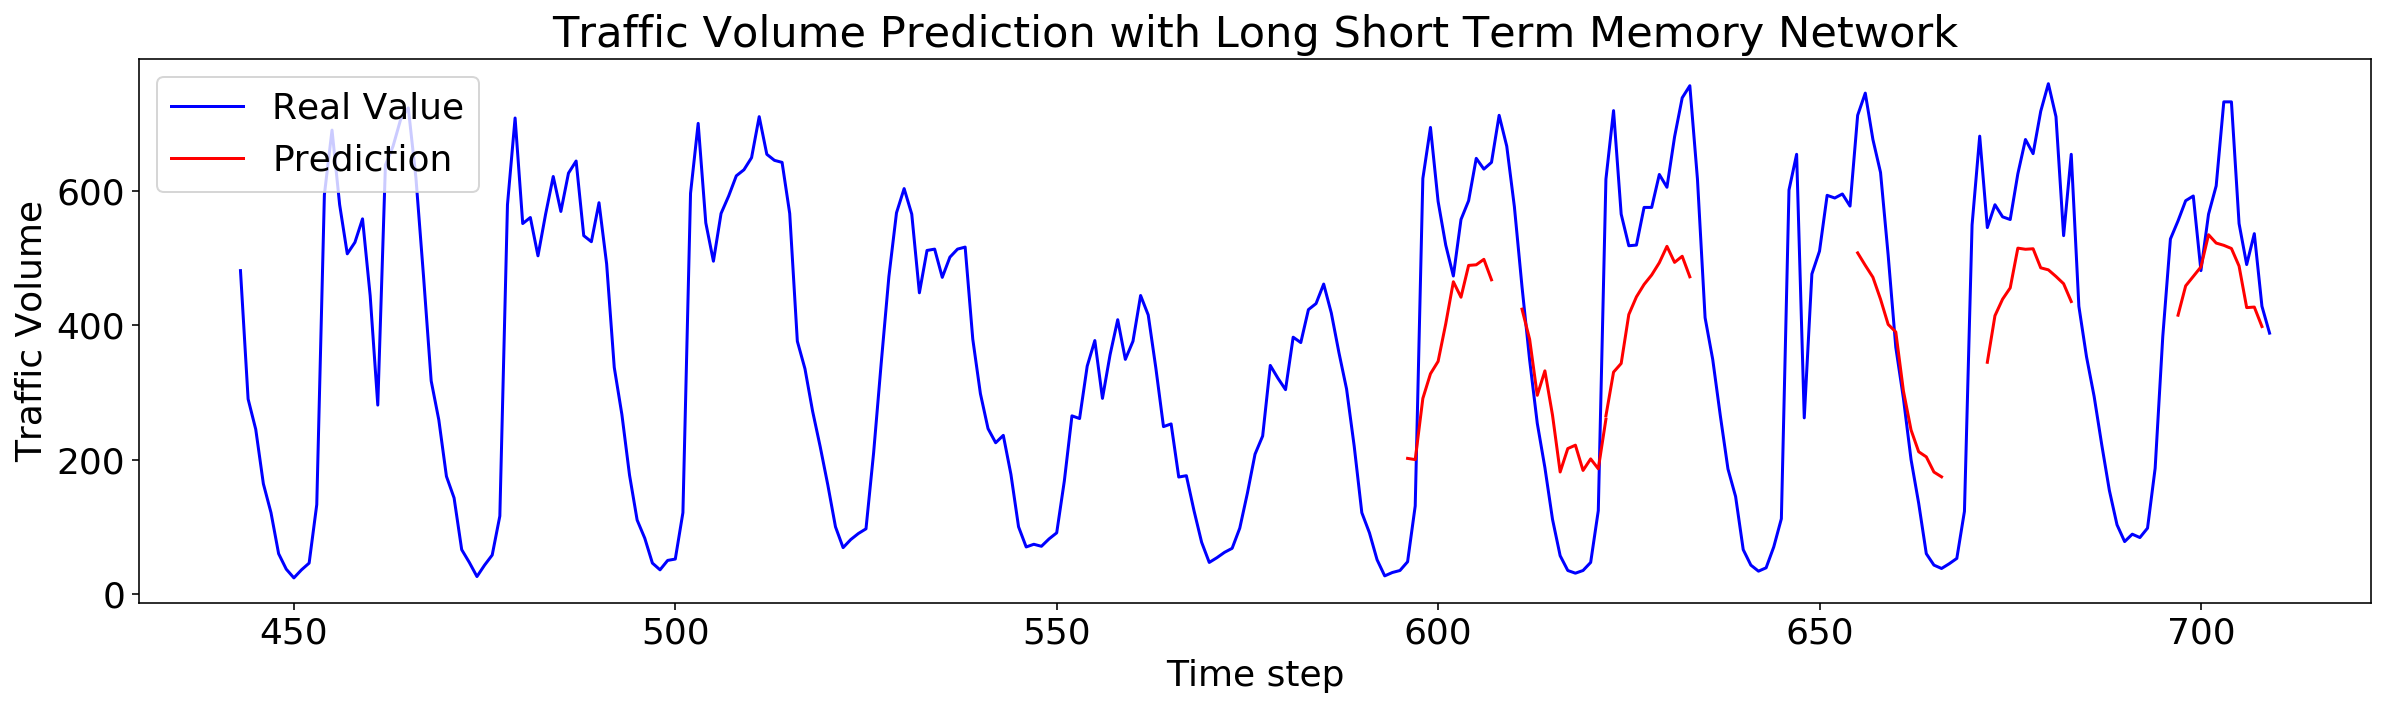

In [154]:
# Create plot with predictions for some observations in the test set.
plt.figure(figsize=(20, 5))
plt.rcParams.update({'font.size': 18})
plt.plot(range(divider,710), df.loc[divider:,"value"], "blue")
pred1 = model.predict(X_test[8:9].reshape(1, 1, 144))
plt.plot(range(divider+144+9,divider+144+9+12), Yscaler.inverse_transform(pred1[0])[0], "red")
pred2 = model.predict(X_test[23:24].reshape(1, 1, 144))
plt.plot(range(divider+144+24,divider+144+24+12), Yscaler.inverse_transform(pred2[0])[0], "red")
pred3 = model.predict(X_test[34:35].reshape(1, 1, 144))
plt.plot(range(divider+144+35,divider+144+35+12), Yscaler.inverse_transform(pred3[0])[0], "red")
pred4 = model.predict(X_test[67:68].reshape(1, 1, 144))
plt.plot(range(divider+144+68,divider+144+68+12), Yscaler.inverse_transform(pred4[0])[0], "red")
pred5 = model.predict(X_test[84:85].reshape(1, 1, 144))
plt.plot(range(divider+144+85,divider+144+85+12), Yscaler.inverse_transform(pred5[0])[0], "red")
pred6 = model.predict(X_test[109:110].reshape(1, 1, 144))
plt.plot(range(divider+144+110,divider+144+110+12), Yscaler.inverse_transform(pred6[0])[0], "red")
plt.legend(["Real Value", "Prediction"], loc="upper left")
plt.xlabel("Time step")
plt.ylabel("Traffic Volume")
plt.title("Traffic Volume Prediction with Long Short Term Memory Network")
plt.savefig("LSTM_predictions.png")

In [155]:
# Max, min and average errors.
diff = abs(np.concatenate([df.loc[divider+144+9:divider+144+9+11,"value"].tolist() - Yscaler.inverse_transform(pred1[0])[0],
     df.loc[divider+144+24:divider+144+24+11,"value"].tolist() - Yscaler.inverse_transform(pred2[0])[0],
     df.loc[divider+144+35:divider+144+35+11,"value"].tolist() - Yscaler.inverse_transform(pred3[0])[0],
     df.loc[divider+144+68:divider+144+68+11,"value"].tolist() - Yscaler.inverse_transform(pred4[0])[0],
     df.loc[divider+144+85:divider+144+85+11,"value"].tolist() - Yscaler.inverse_transform(pred5[0])[0],
     df.loc[divider+144+110:divider+144+110+11,"value"].tolist() - Yscaler.inverse_transform(pred6[0])[0]]))
print("Max error: ", max(diff))
print("Min error: ", min(diff))
print("Average error: ", sum(diff)/len(diff))

Max error:  388.9288635253906
Min error:  5.50958251953125
Average error:  147.82290352715387


Both mean square errors for train and test data are lower than the baseline being the mse for the train data smaller, as expected. With this we can conclude that the model didn’t overfit or underfit the data. 

Looking at the predictions the model learned to predict more accurately the peeks although not perfectly, it usually smooths them, not reaching the maximum real values. The bottom parts are also very well predicted.

# Artificial Neural Network

In [156]:
# Reshape the data to feed the neural network.
X_train = X_train.reshape(len(X_train), n_inputs)
y_train = y_train.reshape(len(y_train), n_outputs)

#### Grid Search to Find the Best Parameters (Hidden Layer Size and Learning Rate)

In [157]:
results = {}
for hls in [50, 100, 150, 200, 300]:
    for lr in [0.1, 0.01, 0.01, 0.0001, 0.000001]:
        mlp = MLPRegressor(hidden_layer_sizes=(hls,), learning_rate_init=lr)
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_train)
        mse_train = mean_squared_error(y_train, y_pred)
        y_pred = mlp.predict(X_test)
        mse_test = mean_squared_error(y_test, y_pred)
        results[(hls, lr)] = [mse_train, mse_test]

#### Best Model

In [158]:
# Create network with the "best" parameters
mlp = MLPRegressor(hidden_layer_sizes=(200,), learning_rate_init=0.01)
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(200,), learning_rate='constant',
             learning_rate_init=0.01, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

#### Test Dataset MSE for NN

In [159]:
y_pred = mlp.predict(X_test.reshape(len(X_test), len(X_test[0])))
sum((y_pred.ravel() - y_test.ravel())**2)/len(y_test.ravel())

0.027645791167399854

#### Train Dataset MSE for NN

In [160]:
y_train_pred = mlp.predict(X_train)
sum((y_train_pred.ravel() - y_train.ravel())**2)/len(y_train.ravel())

0.012826604473182849

In [161]:
# Create plot with predictions for some observations in the test set.
plt.figure(figsize=(20, 5))
plt.rcParams.update({'font.size': 18})
plt.plot(range(divider,710), df.loc[divider:,"value"], "blue")
pred1 = mlp.predict(X_test[9].reshape(1, 144))
plt.plot(range(divider+144+9,divider+144+9+12), Yscaler.inverse_transform(pred1)[0], "red")
pred2 = mlp.predict(X_test[24].reshape(1, 144))
plt.plot(range(divider+144+24,divider+144+24+12), Yscaler.inverse_transform(pred2)[0], "red")
pred3 = mlp.predict(X_test[35].reshape(1, 144))
plt.plot(range(divider+144+35,divider+144+35+12), Yscaler.inverse_transform(pred3)[0], "red")
pred4 = mlp.predict(X_test[68].reshape(1, 144))
plt.plot(range(divider+144+68,divider+144+68+12), Yscaler.inverse_transform(pred4)[0], "red")
pred5 = mlp.predict(X_test[85].reshape(1, 144))
plt.plot(range(divider+144+85,divider+144+85+12), Yscaler.inverse_transform(pred5)[0], "red")
pred6 = mlp.predict(X_test[110].reshape(1, 144))
plt.plot(range(divider+144+110,divider+144+110+12), Yscaler.inverse_transform(pred6)[0], "red")
plt.legend(["Real Value", "Prediction"], loc="upper left")
plt.xlabel("Time step")
plt.ylabel("Traffic Volume")
plt.title("Traffic Volume Prediction with Artificial Neural Network")
plt.savefig("ANN_predictions.png")

In [162]:
# Max, min and average errors.
diff = abs(np.concatenate([df.loc[divider+144+9:divider+144+9+11,"value"].tolist() - Yscaler.inverse_transform(pred1)[0],
     df.loc[divider+144+24:divider+144+24+11,"value"].tolist() - Yscaler.inverse_transform(pred2)[0],
     df.loc[divider+144+35:divider+144+35+11,"value"].tolist() - Yscaler.inverse_transform(pred3)[0],
     df.loc[divider+144+68:divider+144+68+11,"value"].tolist() - Yscaler.inverse_transform(pred4)[0],
     df.loc[divider+144+85:divider+144+85+11,"value"].tolist() - Yscaler.inverse_transform(pred5)[0],
     df.loc[divider+144+110:divider+144+110+11,"value"].tolist() - Yscaler.inverse_transform(pred6)[0]]))
print("Max error: ", max(diff))
print("Min error: ", min(diff))
print("Average error: ", sum(diff)/len(diff))

Max error:  414.9415198987209
Min error:  3.2479554085605287
Average error:  109.64221618281701


Both mean square errors for the train and test data using the best model are lower than the baseline being the mse for the train data smaller, as expected. With this we can conclude that the model didn’t overfit or underfit the data.

Analysing the real and predicted values for some of the windows of the time series we can observe that the model didn't learn to differentiate weekday from weekends, since some peaks are not well predicted, resulting in predictions bellow the expected value.  There is also very good predictions for the bottom parts and the last two peaks are also consistent with the real values.

# Conclusion

Traditional artificial neural networks weren’t designed for predicting time series data they achieve reasonable results. However long short term memory networks are indeed better than traditional neural networks and for more complex problems like machine translation or natural language processing we probably will see a much significance difference between the network’s performances.  

The training time for the models is also very different, being the ANN trained in less than 5 seconds, but it takes at least 6 minutes to train the LSTM on a 1.6GHz dual-core Intel Core i5 for 5000 epochs.  

Even though the results are satisfactory some aspects can be improved, for example the injection of domain knowledge like holidays' dates and if it is weekend or weekday, other variables that also influence traffic intensity like weather and the number of accidents in the road could also be useful.  

Using both models, the LSTM to give a prediction of the traffic intensity and the ANN to use this output along with the other variables to predict a more accurate result could be an interesting approach.